In [2]:
import sys
import string
from os import path
import json
from collections import defaultdict, Counter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
filename = '/home/adam/Workspace/C#/SecStrAnnot2_data/SecStrAPI/PF00067_rp15.txt'
proteins_api_dir = '/home/adam/Workspace/C#/SecStrAnnot2_data/SecStrAPI/protein_api_cyps'

In [4]:
def get_top_taxon_group(accession):
    try:
        with open(path.join(proteins_api_dir, accession + '.json')) as f:
            info = json.load(f)
        group = info['organism']['lineage'][0]
    except FileNotFoundError:
        group = '-'
    return group

def get_source_db(accession):
    try:
        with open(path.join(proteins_api_dir, accession + '.json')) as f:
            info = json.load(f)
        db = info['info']['type']
    except FileNotFoundError:
        db = '-'
    return db

INDEL_CHARS = string.ascii_lowercase + '.'
INDEL_TRANSLATE_TABLE = str.maketrans('', '', INDEL_CHARS)

def remove_indels(sequence: str) -> str:
    return sequence.translate(INDEL_TRANSLATE_TABLE)

def count_residues_between(sequence: str, start: int, end: int):
    return end - start - 1 - sequence.count('-', start+1, end)

In [5]:
posP = 292  # P@J.50
posE, posR = 329, 332  # E@K.50, R@K.53
posC = 411  # C before L ("@L.44")

In [6]:
with open(filename) as f:
    name = None
    sequences = defaultdict(list)
    for line in f:
        line = line.strip()
        if line.startswith('>'):
            name = line[1:]
        else:
            sequences[name].append(line)
sequences = { name.split('/')[0]: ''.join(seq) for name, seq in sequences.items() }
wo_indels = { name: remove_indels(seq) for name, seq in sequences.items() }
meaningful = { name: seq for name, seq in wo_indels.items() if seq[posE]!='-' and seq[posR]!='-' and seq[posC]!='-' }

In [7]:
print(len(meaningful), len(wo_indels))
# print(*meaningful, sep='\n', file=sys.stderr)

20387 25895


In [8]:
groups = np.array([get_top_taxon_group(name) for name in meaningful])
print('GROUPS:', Counter(groups))

GROUPS: Counter({'Eukaryota': 17006, 'Bacteria': 2779, '-': 578, 'Viruses': 13, 'Archaea': 11})


In [9]:
dbs = np.array([get_source_db(name) for name in meaningful])
print('DATABASES:', Counter(dbs))

DATABASES: Counter({'TrEMBL': 19225, 'Swiss-Prot': 584, '-': 578})


In [10]:
countP, countE, countR, countC = Counter(), Counter(), Counter(), Counter()
lengths_P_ER = []
lengths_ER_C = []

for name, seq in meaningful.items():
    countE[seq[posE]] += 1
    countR[seq[posR]] += 1
    countC[seq[posC]] += 1
    lengths_P_ER.append(count_residues_between(seq, posP, posE))
    lengths_ER_C.append(count_residues_between(seq, posR, posC))

names = np.array(list(meaningful))
lengths_P_ER = np.array(lengths_P_ER)
lengths_ER_C = np.array(lengths_ER_C)

In [11]:
print(Counter(lengths_P_ER))
print(Counter(lengths_ER_C))

Counter({36: 13602, 35: 2461, 18: 1061, 34: 662, 33: 429, 4: 204, 32: 195, 3: 179, 5: 148, 7: 133, 6: 123, 1: 110, 19: 106, 31: 99, 9: 78, 29: 75, 23: 73, 30: 61, 2: 52, 20: 50, 8: 50, 27: 46, 15: 37, 0: 34, 28: 33, 17: 31, 24: 30, 11: 30, 21: 27, 10: 25, 22: 23, 25: 23, 26: 22, 13: 22, 12: 21, 16: 19, 14: 13})
Counter({77: 5703, 78: 4851, 76: 4064, 75: 1156, 74: 994, 67: 975, 68: 803, 73: 776, 72: 580, 71: 134, 69: 93, 70: 83, 66: 80, 65: 38, 63: 18, 64: 17, 61: 5, 58: 4, 62: 4, 59: 2, 57: 2, 55: 2, 51: 1, 56: 1, 60: 1})


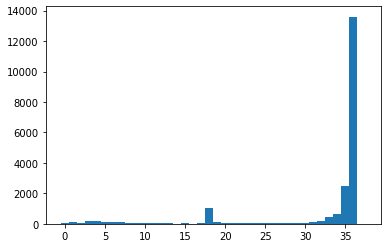

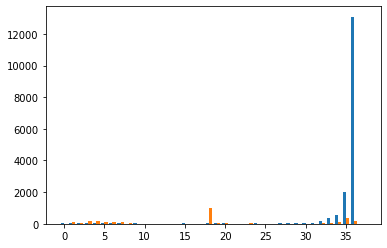

In [12]:
plt.figure()
# plt.subplot(2, 2, 1)
bins_P_ER = np.arange(min(lengths_P_ER)-0.5, max(lengths_P_ER)+2.5)
plt.hist(lengths_P_ER, bins=bins_P_ER)
plt.figure()
# plt.subplot(2, 2, 3)
lE = lengths_P_ER[groups=='Eukaryota']
lB = lengths_P_ER[groups=='Bacteria']
plt.hist([lE, lB], bins=bins_P_ER)
plt.show()

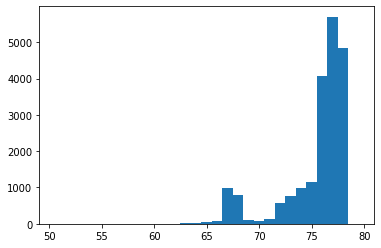

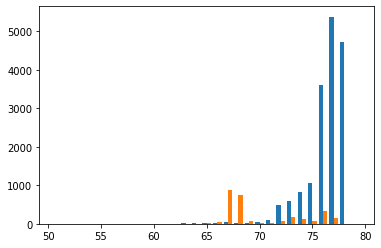

In [13]:
plt.figure()
# plt.subplot(2, 2, 2)
bins_ER_C = np.arange(min(lengths_ER_C)-0.5, max(lengths_ER_C)+2.5)
plt.hist(lengths_ER_C, bins=bins_ER_C)
plt.figure()
# plt.subplot(2, 2, 4)
lE = lengths_ER_C[groups=='Eukaryota']
lB = lengths_ER_C[groups=='Bacteria']
plt.hist([lE, lB], bins=bins_ER_C)
plt.show()

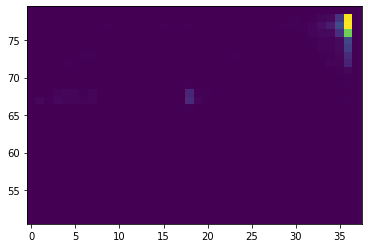

In [14]:
plt.hist2d(lengths_P_ER, lengths_ER_C, bins = (bins_P_ER, bins_ER_C))
plt.show()

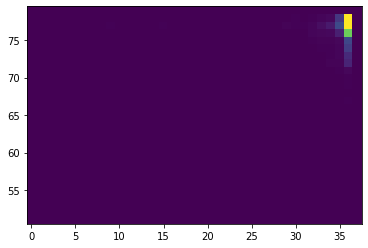

In [15]:
plt.hist2d(lengths_P_ER[groups=='Eukaryota'], lengths_ER_C[groups=='Eukaryota'], bins = (bins_P_ER, bins_ER_C))
plt.show()

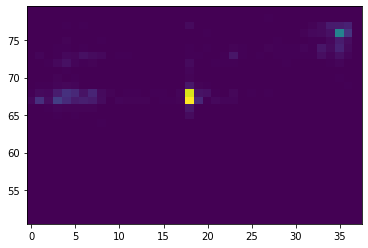

In [16]:
plt.hist2d(lengths_P_ER[groups=='Bacteria'], lengths_ER_C[groups=='Bacteria'], bins = (bins_P_ER, bins_ER_C))
plt.show()

In [21]:
weirdos = names[(groups=='Bacteria') & (lengths_P_ER > 30) & (lengths_ER_C > 70)]
len(weirdos)

672

In [22]:
weirdos_reviewed = names[(groups=='Bacteria') & (lengths_P_ER > 30) & (lengths_ER_C > 70) & (dbs == 'Swiss-Prot')]
sorted(weirdos_reviewed, key=len)

['P9WPP9', 'P9WPN3', 'P9WPM7', 'P9WPM1']